# Kalman Cornerback
##  Comparing defensive back performance to a popular tracking algorithm

This notebook will feed the receiver track data into a Kalman filter tracker algorithm and output a "best case scenario" for a defensive back using all of his senses to read the receivers movement and predict his next move.  

We can then compare that to the DB track data to gain some insight into performance and how it affects the outcome on various plays.  

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Read In Data
track_data = pd.read_csv('../input/nfl-big-data-bowl-2021/week11.csv')
play_data = pd.read_csv('../input/nfl-big-data-bowl-2021/plays.csv')
player_data = pd.read_csv('../input/nfl-big-data-bowl-2021/players.csv')
game_data = pd.read_csv('../input/nfl-big-data-bowl-2021/games.csv')

track_data.head()
play_data.head()

# 2018 ProBowl CBs
## Jalen Ramsey CB - Jacksonville Jaguars
In a parallel notebook I started analyzing the 2018 Pro Bowl CBs in order to "reverse engineer" an ideal CB.  One of the best cornerbacks in 2018 was Jalen Ramsey who made a name for himself that year playing corner for the Jaguars and making his voice heard.  In 2020, Jalen Ramsey was awarded the highest paying contract for a CB by the L.A. Rams.  Recognized as one of the best shutdown corners, he is usually in man-to-man coverage, and I'm initially restricting my analysis to his plays in a single week.  Initially, Week 11 vs. the Steelers where his pass coverage accounted for at least one long completion and one interception.  

In [ ]:
#Single Jalen Ramsey Play

#Grab plays from our current track data frame
jalen_plays = track_data.query("nflId == 2555280")

#Separate by Game and choose one at random (Using Week 11 data, only one game available)
gameIds = jalen_plays.gameId.unique()
ourgameId = np.random.choice(gameIds)

#Find all plays in our game and choose one at random
playIds = jalen_plays.query("gameId == @ourgameId") #This is ALL Jalen Ramsey track data from the game
ourplayId = np.random.choice(playIds.playId.unique())

#Some useful play Ids
#ourplayId = 2608 #Interception
#ourplayId = 3757 #26 yd completion
ourplayId = 1703 #Incomplete Deep Right 
#ourplayId = 1020 #Incomplete short middle
#ourplayId =  3276# Sacked
#ourplayId = 4155 # Deep Left A. Brown 25 yards
#ourplayId = 215# short right JSS 7 yds

#Print relevant play details 
print("Game #:", ourgameId, " Play #:", ourplayId)
our_play_data = play_data.query('gameId == @ourgameId and playId == @ourplayId')
print(our_play_data.playDescription.tolist()[0])

#Sanity check on Jalen Data
jalen_plays.query("playId == @ourplayId").plot(x='time',y='x')

play_data.head()

Saving some useful play info for later...


Game #: 2018111810  Play #: 3757
(3:54) (Shotgun) B.Roethlisberger pass deep left to J.Smith-Schuster to JAX 26 for 21 yards (J.Ramsey).


Game #: 2018111810  Play #: 2608
(8:02) (Shotgun) B.Roethlisberger pass deep middle intended for A.Brown INTERCEPTED by J.Ramsey at JAX -7. J.Ramsey to JAX 43 for 50 yards (B.Roethlisberger). The Replay Official reviewed the runner was down by contact ruling, and the play was REVERSED. (Shotgun) B.Roethlisberger pass deep middle intended for A.Brown INTERCEPTED by J.Ramsey at JAX -7. Touchback (A.Brown).


# **How a Cornerback acts like a "Tracker"**
## How Kalman Filter Error Analysis can help us understand pass coverage

The goal of a defensive back in pass coverage can be simplified and represented by a 2 dimensional tracker not much different than an object tracker built into a camera or radar. 

Spending my career in the defense industry I have implemented various uses of the Kalman filter for tracking and sensor fusion.  

In the defense industry some common sensors are radars and cameras (and by extension sonar and lidar).  A little bit of trivia knowledge for you, radar is itself an acronym standing for "Radio Detection and Ranging".  We can dive into the history of radar and its importance throughout history but we'll stick to football for now.  

Think of a defensive back using his "senses" or "sensors", his eyes, ears, hands, etc. to read the movement of the receiver and try to correctly predict his next move or more direction his next "position" on the field.  

There are nuances about being able to keep a safe separation, simultaneously keep eyes on the receiver and the passer and as this competition will surely show, many more.  But if we assume that the Cornerback has a goal of guessing each next position of the receiver and moving to that exact position, we can use some well understood tracking algorithms to model pass coverage.  If the receiver data we are given is considered "truth" data, we can compare the CB data to an Optimal solution and analyze the data for clues about performance.  

The Kalman filter is one of the algorithms that has multiple books written about it and has many applications, with object track being just one.  The Kalman filter employs an error/update method and constantly provides feedback to the tracker before outputting another guess.  I am choosing to use the Kalman filter tracker over some other common tracking methods.

### Notes on track data

We are provided the player position in X and Y.  While we are provided speed, we can further break down Speed and Acceleration into their X/Y components to be used by the tracker.  In addition, we are provided player orientation, i.e. rotation about the Z-axis.

I have initially decided to perform a "diff" on the X/Y position and time data in order to compute the velocities into their X/Y components.  A further analysis might use the velocity and direction columns and use some simple trigonometry to compute those same components.  

## Resources and Background Info

A good visual look at Kalman Filters if you are unfamiliar:
[http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/](http://)

Some code resources:
https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html
https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/08-Designing-Kalman-Filters.ipynb?viewer=share

My implementation mostly based on this write-up:
https://www.linkedin.com/pulse/2d-object-tracking-tutorial-kalman-filter-matlab-code-al-ahdab/

# Kalman Implementation
We are given some more than enough track information to work with.  

I've chosen to predict the X/Y position and velocity as well as the orientation and angular velocity.  

In the end we'll mostly focus on X/Y position but there may be additional insight to be ascertained from the velocity and orientation data.  

The algorithm is given an initial state (in analysis I've adjust the time to coincide with the ball snap) which is sometime before the ball snap.  In general, the players are mostly "set" when the ball is snapped.  

In laymans terms, we use each data point to predict the next position of the receiver.  We then compare that prediction to the "truth data".  As we loop through the track data, we maintain covariance and gain matrices, which essentially tells us which of our predictions we are able to trust.  

In the tracking world, we can usually dial in our predictions pretty well on a target of constant velocity.  If the target is moving with any acceleration or especially has abrupt change of direction (such as a receiver making a cut), it causes problem for the tracker and may for a short time allow the target to slip from the crosshairs (and perhaps allow a completion).  

In [ ]:
#State Space
# x = [x, y, theta, xdot, ydot, omega]


# State Space Equations
1. k = current state
2. k+1 = next state

These are basic equations of 2-d motion for translation and rotation.



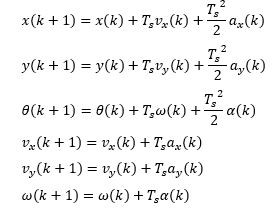

I won't continue to paste the equation photos out, but you can see generally how the equations of motion above turn into matrix math in order to work the tracker.  

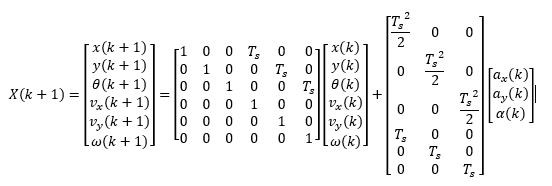

## Useful Player Info to help look at individual plays



In [ ]:
player_data.head()
print('Antonio Brown: ', player_data.query("displayName == 'Antonio Brown'"))
print('JuJu Smith-Schuster: ', player_data.query("displayName == 'JuJu Smith-Schuster'"))



#Our most likely intended receivers

#Antonio Brown:         nflId height  weight   birthDate       collegeName position  \
#101  2508061   5-10     185  07/10/1988  Central Michigan       WR

#JuJu Smith-Schuster:         nflId height  weight   birthDate          collegeName position  \
#105  2558149     73     215  1996-11-22  Southern California       WR 

# Select Receiver Data
We will select the tracker data from the receiver on the play in question.  The cornerback is tasked with "tracking" the receivers motion and placing themselves at or near the next predicted position.  

In [ ]:
#One Play Sample Data
#Use comments to select the receiver on the play 
#Select Receiver, CB and Football track 

#Covering JuJu
sample_data = track_data.query('gameId == @ourgameId and playId == @ourplayId and nflId==2558149' )

#Covering AB
sample_data = track_data.query('gameId == @ourgameId and playId == @ourplayId and nflId==2508061' )

jalen_data = track_data.query('gameId == @ourgameId and playId == @ourplayId and nflId==2555280' )

football_data = track_data.query('gameId == @ourgameId and playId == @ourplayId and displayName=="Football"' )
#football_data.head(50)

In [ ]:
#Play Events to find out pass outcomes i.e. when ball arrives
print(track_data.event.unique())

In [ ]:
#Adjust the time scale to Seconds after ball snap

#Find the Snap Time from the play 
snap_time = track_data.query('gameId == @ourgameId and playId == @ourplayId and event=="ball_snap"' )
snap_time.time = pd.to_datetime(snap_time.time)
snap_time.time = snap_time.time.dt.hour*60*60 + snap_time.time.dt.minute*60+snap_time.time.dt.second+snap_time.time.dt.microsecond*10e-7
snap_time.time = snap_time.time.tolist()[0]
print(snap_time.time)

#Find the Time of Ball Arrival from the play (Arrived for completions, Incomplete/Intercepted for non-completions)
arrived_time = track_data.query('gameId == @ourgameId and playId == @ourplayId  and nflId==2555280 and event=="pass_outcome_incomplete"' )
#arrived_time = track_data.query('gameId == @ourgameId and playId == @ourplayId  and nflId==2555280 and event=="pass_outcome_intercepted"' )
#arrived_time = track_data.query('gameId == @ourgameId and playId == @ourplayId  and nflId==2555280 and event=="pass_arrived"' )

arrived_time.time = pd.to_datetime(arrived_time.time)
arrived_time.time = arrived_time.time.dt.hour*60*60 + arrived_time.time.dt.minute*60+arrived_time.time.dt.second+arrived_time.time.dt.microsecond*10e-7
arrived_time.time = arrived_time.time.tolist()[0] - snap_time.time.tolist()[0]
print(arrived_time.time)
#sample_data = jalen_plays.query("playId == 3757")
#sample_data = jalen_plays.query("playId == 2608")

#Get entire timeline from player tracker data
sample_data.time = pd.to_datetime(sample_data.time)
sample_data.time = sample_data.time.dt.hour*60*60 + sample_data.time.dt.minute*60+sample_data.time.dt.second+sample_data.time.dt.microsecond*10e-7
#print(sample_data.time)

jalen_data.time = pd.to_datetime(jalen_data.time)
jalen_data.time = jalen_data.time.dt.hour*60*60 + jalen_data.time.dt.minute*60+jalen_data.time.dt.second+jalen_data.time.dt.microsecond*10e-7
#print(jalen_data.time)

#Adjust Time to Snap
sample_data.time = sample_data.time -  snap_time.time.tolist()[0]
jalen_data.time = jalen_data.time -  snap_time.time.tolist()[0]



### Using X/Y Tracker Data for Velocity and Acceleration
We compute the "diff" on the X/Y tracker data in order to separate the velocity and acceleration into its X/Y components.  Since velocity is defined in one dimension as "dx/dt" or change in position over time, we use the time "diff" above to ensure we are using the correct "dt".  


In [ ]:
#Compute "dt=change in time" for accurate vel and acc
sample_data['dt']= sample_data.time.diff().fillna(0)
#print(sample_data.time)


#First Derivative = Velocity
sample_data_vx=(sample_data.x.diff().fillna(0).tolist())/sample_data.dt
sample_data_vy=(sample_data.y.diff().fillna(0).tolist())/sample_data.dt
sample_data_vo=(np.radians(sample_data.o.diff().fillna(0).tolist()))/sample_data.dt
#print(sample_data_vx)

#Use Trig to compute Velocity
#sample_data_vx= np.multiply(sample_data.s,np.cos(np.radians(sample_data.o)))
#sample_data_vy= np.multiply(sample_data.s,np.sin(np.radians(sample_data.o)))

#plt.figure()
#plt.plot(sample_data_vx_calc - sample_data_vx)

#Second Derivative = Acceleration
sample_data_ax=(sample_data_vx.diff().fillna(0).tolist())/sample_data.dt
sample_data_ay=(sample_data_vy.diff().fillna(0).tolist())/sample_data.dt

#Use Trig to compute Accelerations
#sample_data_ax= np.multiply(sample_data.a,np.cos(np.radians(sample_data.o)))
#sample_data_ay= np.multiply(sample_data.a,np.sin(np.radians(sample_data.o)))
sample_data_ao=(np.radians(sample_data_vo.diff().fillna(0).tolist()))/sample_data.dt

#Add the columns to our sample data
sample_data['vx']=sample_data_vx
sample_data['vy']=sample_data_vy
sample_data['ax']=sample_data_ax
sample_data['ay']=sample_data_ay
sample_data['vo']=sample_data_ay
sample_data['ao']=sample_data_ay

#print(sample_data.time.diff().fillna(0))
#plt.plot(sample_data.vx)
#plt.plot(sample_data.vy)
#plt.plot(sample_data.s)

#Sanity check ax/ay versus total velocity
plt.figure
plt.plot(sample_data.ax)
plt.plot(sample_data.ay)
plt.plot(sample_data.a)

### Kalman Filter Matrix Math Excitement
The filter math is dense the implementation and can be found in the above provided resources.  I'll add (mostly useless) comments where fitting.  Ignore any print statements as implementing this without a helper library (fyi - I'm told there is a Kalman Filter for python type library) is a lot of matrix math and trying endlessly to keep dimensions in check.      

In [ ]:
#Equations of 2-d motion
dt = np.array(sample_data.dt)   # time step determined by data
i = 0;

#State Matrix
A = np.array([[1, 0, 0, dt[i], 0,  0],
                      [0, 1, 0,  0, dt[i], 0],
                      [0, 0, 1, 0, 0, dt[i]],
                      [0, 0, 0, 1, 0, 0 ],
                      [0, 0, 0, 0, 1, 0 ],
                      [0, 0, 0, 0, 0, 1]])
print("State Matrix= \n", A, ' ', A.shape)

#Output Matrix
C = np.array([[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
print("Output Matrix= \n", C, ' ', C.shape)

#Input Matrix
B = np.array([[0.5*np.square(dt[i]), 0, 0],
              [0, 0.5*np.square(dt[i]), 0],
              [0, 0, 0.5*np.square(dt[i])],
              [dt[i], 0, 0],
              [0, dt[i], 0],
              [0, 0, dt[i]]]); 
print("Input Matrix= \n", B, ' ', B.shape)

print("Total Data Points: ", dt.size)

In [ ]:
#Initial Conditions

#Set the actual initial conditions ([x,y,o,xdot,ydot,0dot])
#Track the receiver (not the DB)
x0 = sample_data
#x0.head()
x0 = np.array([[x0.x.tolist()[0]],
               [x0.y.tolist()[0]],
               [np.radians(x0.o.tolist()[0])],
               [0],
               [0],
               [0]])  #Keep these as zeros (i.e. initial velocities are zero as receiver comes set)
      
print("Initial Conditions \n", x0)
print(x0.shape)

# Acceleration is vital
(Directional)change in velocity is what makes it so difficult for a cornerback to track a receiver.  A recievers cuts and route specifics determine how and when they are going to accelerate and deccelerate.  Unfortunately, the receiver is not privileged to the acceleration data in real time.  They have to use all of their senses to perceive the movement of the receiver and use that information to guess where the receiver will move to next.  Our tracker assumes some amount of uncertainty is involved with this measurement.  

This is a place where things get interesting and we have to do some interpretation.  Since we have the measured "truth" data, after the fact, we're able to plug in very small values for uncertainty and have our tracker output an extremely accurate track.  

We can compare the cornerback performance to the "perfect" track to evaluate.  Later, we can introduce error into the equations and see just how much error needs introduced in order to emulate the cornerback's track.  


In [ ]:
#Assign the acceleration from the tracker data and put it in an array

#Assign from measurement data
ux=np.array(sample_data.ax.fillna(0))
uy=np.array(sample_data.ay.fillna(0))
utheta=np.array(sample_data.ao.fillna(0))

#Combine
u = np.array([np.transpose(ux),np.transpose(uy), np.transpose(utheta)])
u=np.transpose(u)
#print(u)

#Accuracy of the acceleration data
segmaux=.2 #standard deviation ax
segmauy=.2 #standard deviation ay
segmaualpha=.05 #standard deviation angular acceleration

# Variance in measurement data
measurementsV=np.array([[np.square(.5), 0, 0],[0, np.square(.5), 0],[0, 0, np.square(.05)]]);
print(measurementsV)
print(measurementsV.shape)


In [ ]:
#Initializing the estimation matricies for the for loop 
Xest=np.zeros((6,dt.size))
print(Xest.shape)

Xest[:,0]=np.transpose(x0)
#print(x0)
print(Xest)

#Estimate 2 is sanity check, applying only the equations of motion and no tracker theory 
#Essentially is a linear interpolation
Xest2=np.zeros((6,dt.size))
print(Xest.shape)

Xest2[:,0]=np.transpose(x0)
#print(x0)
print(Xest)

# Notes on sensors and estimation


In [ ]:
#Define R and Q

#Covariance and Kalman Gain
R=measurementsV.dot(C).dot(np.transpose(C))
Q=np.array([[np.square(segmaux), 0, 0],  [0, np.square(segmauy), 0], [0, 0, np.square(segmaualpha)]]);
print(R), print(R.shape)
print(Q),print(Q.shape)

#Allocate Matrices to save as we go
Rmat = np.zeros(shape=(3, 3, dt.size))
Qmat = np.zeros(shape=(3, 3, dt.size))
Kmat = np.zeros(shape=(6, 3, dt.size))

In [ ]:
#Initializing P (Prediction Matrix)

P=B.dot(Q).dot(np.transpose(B))
#P=np.zeros(shape=(6,6))
print(P, 'P Shape: ', P.shape)

Pmat = np.zeros(shape=(6, 6, dt.size))
print(Pmat.shape)
Pmat[:,:,0]=P
#print(Pmat[:,:,0])

In [ ]:
#Kalman filter in action:

for i in range(1,dt.size):
    P=A.dot(P).dot(np.transpose(A))+B.dot(Q).dot(np.transpose(B)); #predicting P
    #print(P)
    A = np.array([[1, 0, 0, dt[i], 0,  0],
                      [0, 1, 0,  0, dt[i], 0],
                      [0, 0, 1, 0, 0, dt[i]],
                      [0, 0, 0, 1, 0, 0 ],
                      [0, 0, 0, 0, 1, 0 ],
                      [0, 0, 0, 0, 0, 1]])
    B = np.array([[0.5*np.square(dt[i]), 0, 0],
              [0, 0.5*np.square(dt[i]), 0],
              [0, 0, 0.5*np.square(dt[i])],
              [dt[i], 0, 0],
              [0, dt[i], 0],
              [0, 0, dt[i]]]); 


    #print("Test Xest, one line size: ", Xest[:,1].shape)
    #print("A Shape ", A.shape, "Xest[i-1] Shape Trans: ", np.transpose(Xest[:,i-1]).shape, " B Shape ", B.shape, "u[i-1] shape ", u[i-1].shape)
    Xest[:,i]=A.dot(Xest[:,i-1])+B.dot(u[i-1])
    Xest2[:,i]=A.dot(Xest2[:,i-1])+B.dot(u[i-1])
    
    #print("A: ", A, A.shape)
    #print(np.transpose((Xest[i-1])),np.transpose((Xest[i-1])).shape )
    #print("B: ", B, B.shape)
    #print("u:", u[i-1])
    #print(Xest[0,:])
    print("P: ", P," ", P.shape)
    print("C: ", C," ", C.shape)
    print("R: ", R," ", R.shape)
    

    K=P.dot(np.transpose(C))#/(C*P*C'+R)#calculating the Kalman gains
    Kdenom = C.dot(P).dot(np.transpose(C)) + R
    #print(np.linalg.inv(Kdenom))
    K = K.dot(np.linalg.inv(Kdenom))
    #Kalt = np.divide(K,Kdenom)
    Kmat[:,:,i]=K
    print("K: ", K," ", K.shape)
    print("Kdenom: ", Kdenom," ", Kdenom.shape)
    
    #print("C:", C.dot(Xest[:,i]), " ", C.dot(Xest[:,i]).shape)
    meas = np.array([sample_data.x.tolist()[i],sample_data.y.tolist()[i],np.radians(sample_data.o.tolist()[i])])
    print('Meas: ',meas)
    print("meas-cdot: ",meas-C.dot(Xest[:,i]), " ",(meas-C.dot(Xest[:,i])).shape)
    #print("Xest1.shape: ", Xest[:,i].shape)
    Xest[:,i]=Xest[:,i] + K.dot(meas-C.dot(Xest[:,i]))#Correcting: estimating the state
    P=(np.eye(6)-K.dot(C)).dot(P)  #Correcting: estimating P
    Pmat[:,:,i]=P
    #print("P: ", P," ", P.shape)

In [ ]:
#Some analysis:

#I'll run a few plays through and take the analysis offline to annotate

#Plot Error in X,Y and total error
fig1 = plt.figure(figsize=(12,8))
ax11 = fig1.add_subplot(1, 1, 1) 
ax11.plot(sample_data.time,Xest[0,:]- jalen_data.x.tolist(), label='X error (N:S)')#jalen to rcvr in X
ax11.plot(sample_data.time,Xest[1,:]- jalen_data.y.tolist(), label='Y error (Sideline to Sideline)')#jalen to rcvr in y
plt.plot(sample_data.time,np.sqrt(np.square(Xest[0,:]-jalen_data.x.tolist()) + np.square(Xest[1,:]-jalen_data.y.tolist())),label='Total Error (Yds)',color='red')
plt.axvline(x=arrived_time.time.tolist()[0])
ax11.set_title('CB vs Kalman Tracker')
ax11.set_xlabel('Time (s) After Snap')
ax11.set_ylabel('CB Error (yards)')
ax11.legend()

fig2 = plt.figure(figsize=(12,8))
ax22 = fig2.add_subplot(1, 1, 1) 
ax22.plot(sample_data.time,Xest2[0,:]- jalen_data.x.tolist(), label='X error (N:S)')#jalen to rcvr in X
ax22.plot(sample_data.time,Xest2[1,:]- jalen_data.y.tolist(), label='Y error (Sideline to Sideline)')#jalen to rcvr in y
plt.plot(sample_data.time,np.sqrt(np.square(Xest2[0,:]-jalen_data.x.tolist()) + np.square(Xest2[1,:]-jalen_data.y.tolist())),label='Total Error (Yds)', color='red')
plt.axvline(x=arrived_time.time.tolist()[0])
ax22.set_title('CB vs Interpolation Tracker')
ax22.set_xlabel('Time (s) After Snap')
ax22.set_ylabel('CB Error (yards)')
ax22.legend()

fig3 = plt.figure(figsize=(12,8))
ax33 = fig3.add_subplot(1, 1, 1) 
ax33.scatter(Xest[0,:], Xest[1,:], label = 'Tracker Estimate for Rcvr')
ax33.scatter(jalen_data.x.tolist(), jalen_data.y.tolist(), label = 'Jalen Ramsey')
ax33.scatter(sample_data.x.tolist(), sample_data.y.tolist(), label = 'Actual Rcvr Position')
ax33.scatter(football_data.x.tolist(), football_data.y.tolist(), label = 'Football', color='brown')
#plt.plot(Xest[0,:]- Xest2[0,:])
#plt.plot(Xest[1,:]- Xest2[1,:])
ax33.set_title('CB vs Kalman Tracker')
ax33.set_xlabel('X Position')
ax33.set_ylabel('Y Position')
ax33.legend()


# Info Gleaning
## Observations
* We can see some inflections in the total error which coincide with the receiver making even subtle moves.
* We notice the Kalman filter is fooled at times versus a linear interpolation tracker, which is to be expected for short bursts by the receiver, because the Kalman filter takes a more realistic amount of time to adjust. This error is meant to represent how hard it is to track fast moving, accelerating objects over short periods of time.
* Not unexpectedly, Jalen Ramsey seems to minimize their distance error at the point of arrival and completions require the ball to arrive before the distance between he and the receiver closes.  


## Further analysis
* Would like to see how various CBs perform over the course of a game or a season versus other CBs.  Instead of measuring the minimum distance between the CB and receiver over plays, you instead measure distance between the CB and the expected WR track.  
* Would like to look further at the change in total X/Y error at certain points against various routes.  Where the error right now is in position, taking the difference over time could show how badly a CB bites (as mentioned above, some error is to be expected) and how fast they are able to recover if they are beaten at any point in the route.  


![](http://)